<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

# Simple GAN [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/iis-siium/GSN_2/blob/master/GSN2_lab_6_GAN.ipynb)

Simple implementation of Generative Adversarial network


Based on: https://towardsdatascience.com/writing-your-first-generative-adversarial-network-with-keras-2d16fd8d4889


In [1]:
%tensorflow_version 1.x 
%matplotlib inline

TensorFlow 1.x selected.


In [2]:
import keras
from keras import backend
from keras.datasets import fashion_mnist, mnist
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)
latent_dim = 100
optimizer = Adam(0.0002, 0.5)


Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
useFashionMNIST = False

In [0]:
def build_discriminator():
    model = Sequential()

    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    img = Input(shape=img_shape)
    validity = model(img)
    return Model(img, validity)

In [0]:
def build_generator():
    model = Sequential()

    model.add(Dense(256, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))
    model.summary()
    noise = Input(shape=(latent_dim,))
    img = model(noise)
    return Model(noise, img)

In [0]:
try:
    from google.colab import drive
except ModuleNotFoundError as colab_not_found:
    raise ModuleNotFoundError('Only run this cell on google colab!') from colab_not_found

# implementation of wasserstein loss
def wasserstein_loss(y_true, y_pred):
    return keras.backend.mean(y_true * y_pred)

In [7]:
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
                            optimizer=optimizer,
                            metrics=['accuracy'])
generator = build_generator()

z = Input(shape=(latent_dim,))
img = generator(z)
discriminator.trainable = False
validity = discriminator(img)
combined = Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
________________________________________________

In [0]:
def sample_images(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, latent_dim))
    gen_imgs = generator.predict(noise)
    gen_imgs = 0.5 * gen_imgs + 0.5
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    plt.show(block = False)
    plt.close()

In [0]:
def train(epochs, batch_size=128, sample_interval=50):
    if useFashionMNIST is True:
      inputDataset = keras.datasets.fashion_mnist
    else:
      inputDataset = keras.datasets.mnist


    (train_x, train_y), (test_x, test_y) = inputDataset.load_data()
    X_train = np.vstack((train_x, test_x))
    
    X_train = np.expand_dims(X_train, axis=3)
    X_train = X_train / 127.5 - 1. # normalizing to -1:1
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    # valid = np.random.uniform(low=0.7, high=1.3, size=(batch_size, 1)) # apply label smoothing
    # fake = np.random.uniform(low=0, high=0.3, size=(batch_size, 1)) # apply label smoothing

    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        gen_imgs = generator.predict(noise)

        # Train the discriminator
        discriminator.trainable = True # make sure it is trained when dessired
        d_loss_real = discriminator.train_on_batch(imgs, valid)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator
        discriminator.trainable = False
        g_loss = combined.train_on_batch(noise, valid)

        print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100 * d_loss[1], g_loss))
        if epoch % sample_interval == 0:
            sample_images(epoch)

11493376/11490434 [==============================] - 1s 0us/step

0 [D loss: 0.861022, acc.: 12.88%] [G loss: 0.687139]


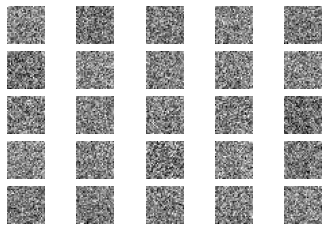

Streaming output truncated to the last 5000 lines.
2 [D loss: 0.357115, acc.: 78.79%] [G loss: 0.671235]
3 [D loss: 0.350609, acc.: 78.79%] [G loss: 0.708518]
4 [D loss: 0.341017, acc.: 81.82%] [G loss: 0.767189]
5 [D loss: 0.320283, acc.: 87.50%] [G loss: 0.865355]
6 [D loss: 0.280340, acc.: 95.83%] [G loss: 1.002463]
7 [D loss: 0.251718, acc.: 96.97%] [G loss: 1.108428]
8 [D loss: 0.213076, acc.: 99.62%] [G loss: 1.282201]
9 [D loss: 0.190403, acc.: 99.62%] [G loss: 1.377199]
10 [D loss: 0.170883, acc.: 99.62%] [G loss: 1.502081]
11 [D loss: 0.147115, acc.: 100.00%] [G loss: 1.683280]
12 [D loss: 0.129302, acc.: 100.00%] [G loss: 1.839707]
13 [D loss: 0.116660, acc.: 99.62%] [G loss: 1.912768]
14 [D loss: 0.099054, acc.: 100.00%] [G loss: 2.092446]
15 [D loss: 0.095639, acc.: 100.00%] [G loss: 2.138420]
16 [D loss: 0.085186, acc.: 100.00%] [G loss: 2.322544]
17 [D loss: 0.071944, acc.: 100.00%] [G loss: 2.441834]
18 [D loss: 0.068396, acc.: 100.00%] [G loss: 2.410313]
19 [D loss: 0.0

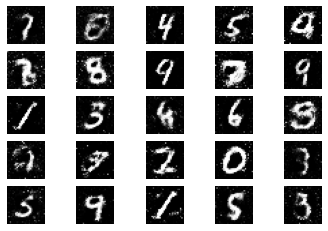

Streaming output truncated to the last 5000 lines.
5002 [D loss: 0.646655, acc.: 62.12%] [G loss: 0.872257]
5003 [D loss: 0.669400, acc.: 58.33%] [G loss: 0.830359]
5004 [D loss: 0.691245, acc.: 54.55%] [G loss: 0.832837]
5005 [D loss: 0.683275, acc.: 57.20%] [G loss: 0.816571]
5006 [D loss: 0.643965, acc.: 63.64%] [G loss: 0.869930]
5007 [D loss: 0.658092, acc.: 59.85%] [G loss: 0.864293]
5008 [D loss: 0.669080, acc.: 58.33%] [G loss: 0.849103]
5009 [D loss: 0.668251, acc.: 59.09%] [G loss: 0.844277]
5010 [D loss: 0.668708, acc.: 62.88%] [G loss: 0.833545]
5011 [D loss: 0.662360, acc.: 60.23%] [G loss: 0.826790]
5012 [D loss: 0.656989, acc.: 61.36%] [G loss: 0.844628]
5013 [D loss: 0.647348, acc.: 67.05%] [G loss: 0.840126]
5014 [D loss: 0.664075, acc.: 56.44%] [G loss: 0.853943]
5015 [D loss: 0.655288, acc.: 62.88%] [G loss: 0.855311]
5016 [D loss: 0.648827, acc.: 64.02%] [G loss: 0.881015]
5017 [D loss: 0.666468, acc.: 59.09%] [G loss: 0.864734]
5018 [D loss: 0.669240, acc.: 57.95%]

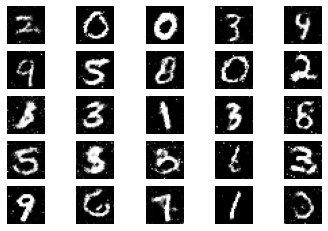

Streaming output truncated to the last 5000 lines.
10002 [D loss: 0.692688, acc.: 53.03%] [G loss: 0.816108]
10003 [D loss: 0.661983, acc.: 58.71%] [G loss: 0.852098]
10004 [D loss: 0.705153, acc.: 48.86%] [G loss: 0.829258]
10005 [D loss: 0.670859, acc.: 57.95%] [G loss: 0.862739]
10006 [D loss: 0.672206, acc.: 58.33%] [G loss: 0.820170]
10007 [D loss: 0.695665, acc.: 51.89%] [G loss: 0.812498]
10008 [D loss: 0.668299, acc.: 57.20%] [G loss: 0.862017]
10009 [D loss: 0.685945, acc.: 59.09%] [G loss: 0.817264]
10010 [D loss: 0.682164, acc.: 57.20%] [G loss: 0.838049]
10011 [D loss: 0.671706, acc.: 56.44%] [G loss: 0.860901]
10012 [D loss: 0.686625, acc.: 50.76%] [G loss: 0.853685]
10013 [D loss: 0.671147, acc.: 58.71%] [G loss: 0.841910]
10014 [D loss: 0.693135, acc.: 55.68%] [G loss: 0.834149]
10015 [D loss: 0.691979, acc.: 56.82%] [G loss: 0.812533]
10016 [D loss: 0.681655, acc.: 53.41%] [G loss: 0.843741]
10017 [D loss: 0.690459, acc.: 55.68%] [G loss: 0.805580]
10018 [D loss: 0.6856

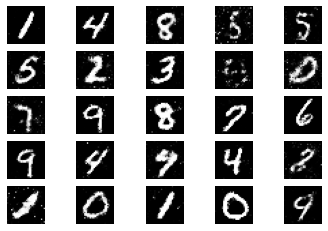

Streaming output truncated to the last 5000 lines.
15002 [D loss: 0.685804, acc.: 55.30%] [G loss: 0.857105]
15003 [D loss: 0.683631, acc.: 55.30%] [G loss: 0.868362]
15004 [D loss: 0.692017, acc.: 54.17%] [G loss: 0.832217]
15005 [D loss: 0.673757, acc.: 56.44%] [G loss: 0.867054]
15006 [D loss: 0.674430, acc.: 56.82%] [G loss: 0.844328]
15007 [D loss: 0.661389, acc.: 62.12%] [G loss: 0.844418]
15008 [D loss: 0.675951, acc.: 59.47%] [G loss: 0.839827]
15009 [D loss: 0.653276, acc.: 61.36%] [G loss: 0.853225]
15010 [D loss: 0.670983, acc.: 55.30%] [G loss: 0.841369]
15011 [D loss: 0.686885, acc.: 56.44%] [G loss: 0.827935]
15012 [D loss: 0.687315, acc.: 57.58%] [G loss: 0.853103]
15013 [D loss: 0.688895, acc.: 55.30%] [G loss: 0.837119]
15014 [D loss: 0.671589, acc.: 53.79%] [G loss: 0.851756]
15015 [D loss: 0.678058, acc.: 55.30%] [G loss: 0.846412]
15016 [D loss: 0.683208, acc.: 57.20%] [G loss: 0.817289]
15017 [D loss: 0.672664, acc.: 58.33%] [G loss: 0.842832]
15018 [D loss: 0.6849

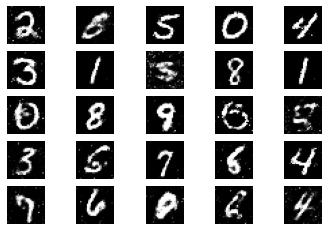

Streaming output truncated to the last 5000 lines.
20002 [D loss: 0.657634, acc.: 60.98%] [G loss: 0.895583]
20003 [D loss: 0.695538, acc.: 51.14%] [G loss: 0.850856]
20004 [D loss: 0.676880, acc.: 56.82%] [G loss: 0.829915]
20005 [D loss: 0.674372, acc.: 54.17%] [G loss: 0.871040]
20006 [D loss: 0.661203, acc.: 57.95%] [G loss: 0.900045]
20007 [D loss: 0.671637, acc.: 56.44%] [G loss: 0.846866]
20008 [D loss: 0.678176, acc.: 56.06%] [G loss: 0.841220]
20009 [D loss: 0.681186, acc.: 55.68%] [G loss: 0.849775]
20010 [D loss: 0.672289, acc.: 59.85%] [G loss: 0.864120]
20011 [D loss: 0.683333, acc.: 54.55%] [G loss: 0.840612]
20012 [D loss: 0.668260, acc.: 57.58%] [G loss: 0.830429]
20013 [D loss: 0.671660, acc.: 56.06%] [G loss: 0.860092]
20014 [D loss: 0.688735, acc.: 55.30%] [G loss: 0.870169]
20015 [D loss: 0.690128, acc.: 55.30%] [G loss: 0.827332]
20016 [D loss: 0.653144, acc.: 62.88%] [G loss: 0.862701]
20017 [D loss: 0.675810, acc.: 54.55%] [G loss: 0.831006]
20018 [D loss: 0.6646

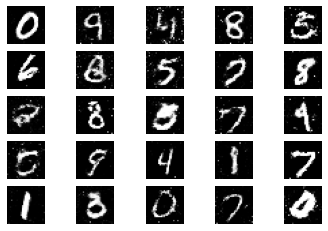

25001 [D loss: 0.676492, acc.: 55.68%] [G loss: 0.869064]
25002 [D loss: 0.674322, acc.: 61.36%] [G loss: 0.835000]
25003 [D loss: 0.666457, acc.: 61.36%] [G loss: 0.849632]
25004 [D loss: 0.664464, acc.: 58.71%] [G loss: 0.872489]
25005 [D loss: 0.673341, acc.: 58.71%] [G loss: 0.837658]
25006 [D loss: 0.696261, acc.: 54.55%] [G loss: 0.866700]
25007 [D loss: 0.678621, acc.: 57.95%] [G loss: 0.849249]
25008 [D loss: 0.663924, acc.: 56.44%] [G loss: 0.864501]
25009 [D loss: 0.673677, acc.: 57.58%] [G loss: 0.900045]
25010 [D loss: 0.672131, acc.: 59.09%] [G loss: 0.872884]
25011 [D loss: 0.669989, acc.: 57.95%] [G loss: 0.841101]
25012 [D loss: 0.687996, acc.: 56.06%] [G loss: 0.857914]
25013 [D loss: 0.666732, acc.: 57.95%] [G loss: 0.875805]
25014 [D loss: 0.679373, acc.: 51.14%] [G loss: 0.840093]
25015 [D loss: 0.657423, acc.: 61.36%] [G loss: 0.886654]
25016 [D loss: 0.650372, acc.: 63.26%] [G loss: 0.877425]
25017 [D loss: 0.658727, acc.: 60.98%] [G loss: 0.874477]
25018 [D loss:

KeyboardInterrupt: ignored

In [10]:
train(epochs=100000, batch_size=132, sample_interval=5000)